In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import interpolate
import datetime

In [2]:
df = pd.read_csv("Out14.csv")

In [3]:
df.head()

,Unnamed: 0,lon,lat,date
0,0,61.4556,55.1146,2020-02-25 23:16:05
1,1,61.4557,55.1144,2020-02-25 23:17:07
2,2,61.4555,55.1144,2020-02-25 23:17:25
3,3,61.4555,55.1144,2020-02-25 23:22:40
4,4,61.4556,55.1144,2020-02-25 23:23:19


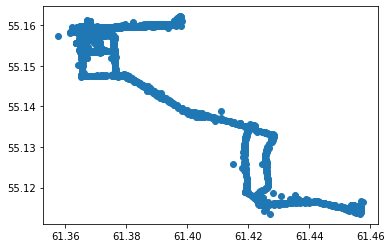

In [4]:
plt.scatter(df.lon,df.lat)

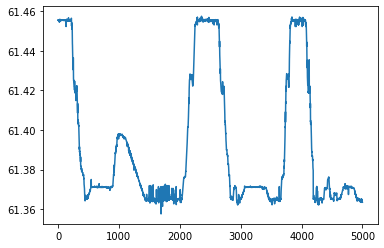

In [5]:
plt.plot(df.lon)

Фильтруем с помощью калмана

In [6]:
N=df.shape[0]
dNoise = 1 
dSignal = 5
r = 0.9999999 
en = 0.9
M = 2

z = np.array(df[["lat","lon"]])
x = np.zeros(N)
for i in range(1, N):
    x[i] = r * x[i - 1] + np.random.normal(0, en)

x = np.zeros(N * M).reshape(N, M)
R = np.array([[r, 0], [0, r]])
Vksi = np.eye(M) * en
V = np.eye(M) * dNoise
x[:][0] = np.random.normal(0, dSignal, M) 
for i in range(1, N):
    x[:][i] = np.dot(R, x[:][i - 1]) + np.random.normal(0, en, M)

xx = np.zeros(N * M).reshape(N, M)
P = np.zeros(M * M).reshape(M, M) 
xx[:][0] = z[:][0]  
P = V  

Vinv = np.linalg.inv(V) 
for i in range(1, N):
    Pe = np.dot(np.dot(R, P), R.T) + Vksi
    P = np.dot(Pe, V) * np.linalg.inv(Pe + V)
    xe = np.dot(R, xx[:][i - 1])
    xx[:][i] = xe + np.dot(np.dot(P, Vinv), (z[:][i] - xe))
xx = xx.transpose()

In [7]:
df["lat_kalman"]=xx[0]
df["lon_kalman"]=xx[1]

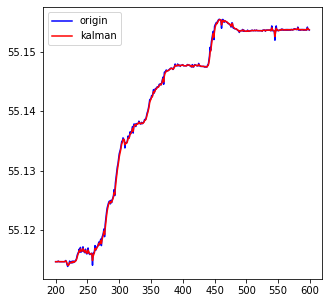

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(df.lat[200:600], color='blue',label="origin")
ax.plot(df.lat_kalman[200:600], color='red',label="kalman")
ax.legend(loc='upper left')
plt.show()

Нормируем время от получения первой точки

In [9]:
df.date = df.date.apply(lambda x: datetime.datetime.fromisoformat(x))
start=df.date.iloc[0]
df["nom"]=[(x-start).total_seconds() for x in df.date]

Расчет скорости с помощью метода наименьших квадратов

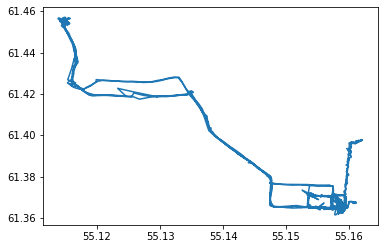

In [10]:
df = df.drop_duplicates(subset='nom', keep="last")
df_iter = df[["nom","lon_kalman","lat_kalman"]]
tck = interpolate.interp1d(df_iter.nom, df_iter.lon_kalman) #линейно интерполируе
                                                            #данные так как частота получения точек не равномерна
x = np.arange(df.nom.min(),df.nom.max(),10) # берем частоту дискретизации в 10 с.
y_lon = tck(x)
tck = interpolate.interp1d(df_iter.nom, df_iter.lat_kalman)
y_lat = tck(x)
plt.plot(y_lat,y_lon)
plt.show()
from scipy import interpolate
j=0
p_lat=[]
p_lon=[]
#Опреелеям скорость на 5 точках
for i in range(5,x.shape[0]):
    buf=[0,1,2,3,4]
    x=np.array([y_lat[i-5:i],y_lon[i-5:i]]).T
    buf=np.vstack([buf, np.ones(len(x))]).T
    p_lat.append(np.linalg.lstsq(buf, y_lat[i-5:i], rcond=None)[0][0])
    p_lon.append(np.linalg.lstsq(buf, y_lon[i-5:i], rcond=None)[0][0])
    


фильтрация шумов в скорости

In [11]:
from queue import Queue
N=len(p_lat)
dNoise = 6000
dSignal = 1
r = 0.9 
en = 1
M = 2

z = np.array([p_lat,p_lon]).T
x = np.zeros(N) 
for i in range(1, N): 
    x[i] = r * x[i - 1] + np.random.normal(0, en)

x = np.zeros(N * M).reshape(N, M)
R = np.array([[r, 0], [0, r]])
Vksi = np.eye(M) * en
V = np.eye(M) * dNoise
x[:][0] = np.random.normal(0, dSignal, M)  
for i in range(1, N):  
    x[:][i] = np.dot(R, x[:][i - 1]) + np.random.normal(0, en, M)

xx = np.zeros(N * M).reshape(N, M)
P = np.zeros(M * M).reshape(M, M)  
xx[:][0] = z[:][0] 
P = V 

Vinv = np.linalg.inv(V)  
for i in range(1, N):
    Pe = np.dot(np.dot(R, P), R.T) + Vksi
    P = np.dot(Pe, V) * np.linalg.inv(Pe + V)
    xe = np.dot(R, xx[:][i - 1])
    xx[:][i] = xe + np.dot(np.dot(P, Vinv), (z[:][i] - xe))
xx = xx.transpose()


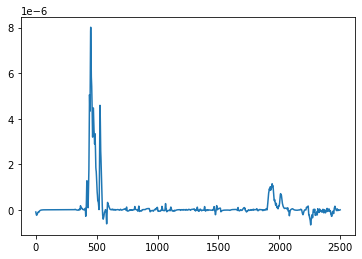

In [12]:
plt.plot(xx[0][4000:6500])

Определеям участки с наличием скорости

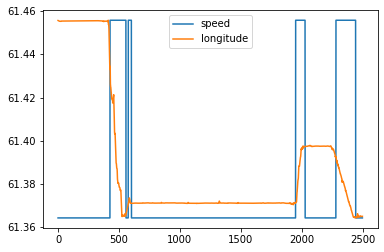

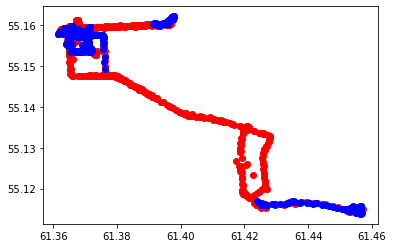

In [13]:
i,j=(4000,6500)
size=0.1
size_window=10
window = np.ones(size_window)
window = list(window)
filt_signal=[]
last_signal=5
x_speed=list(np.ones(size_window))
y_speed=list(np.ones(size_window))
for x in xx.T:
    signal = 0.0
    
    if(np.abs(x[0])>size*10**-6 or np.abs(x[1])>2*size*10**-6):
        if(np.abs(np.sum(x_speed))>size*10**-4 or np.abs(np.sum(y_speed))>size*10**-4):
            signal = 1.0
    #Во избежание дребезжания переключаемся в только в случае заполнение окна
    if(window.count(signal)==size_window):
        last_signal = signal

    x_speed.pop(0)   
    y_speed.pop(0)   
    window.pop(0)
    window.append(signal)
    x_speed.append(x[0])    
    y_speed.append(x[1])
    filt_signal.append(last_signal)

plt.plot([y_lon[i:j].max() if x==1 else y_lon[i:j].min() for x in filt_signal[i:j]],label="speed")
plt.plot(np.array(y_lon[i:j]),label="longitude")
plt.legend()
plt.show()
#plt.plot([df.lat_kalman[i:j].max() if x==1 else df.lat_kalman[i:j].min() for x in filt_signal[i:j]])
timedelta_object = datetime.timedelta(days=0, seconds=10, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
start = df.date.iloc[0]

date_nom=[start+timedelta_object*x for x in range(y_lat.shape[0])]
df_norm = pd.DataFrame(np.array([y_lon[5:],y_lat[5:],date_nom[5:],filt_signal]).T,columns=["lon","lat","date","speed"])
df_s=df_norm[df_norm.speed==1]
df_p=df_norm[df_norm.speed==0]
plt.scatter(df_s.lon,df_s.lat,color="red")
plt.scatter(df_p.lon,df_p.lat,color="blue")
plt.show()

Разбиваем события с помощью скоростны участков

In [14]:
check=0
buf=0
event=[]
for i,item in df_norm.iterrows():
    if buf == 1 and item.speed==0:
        buf = 0
        check=i
        start=item.date
    if buf == 0 and item.speed==1:
        buf = 1
        event.append((start,item.date,df_norm[check:i].lat.describe().top,df_norm[check:i].lon.describe().top))
        

In [15]:
df_event = pd.DataFrame(event, columns=["start","end","lat","lon"])
df_event

,start,end,lat,lon
0,2020-02-25 23:16:05,2020-02-25 23:16:55,NaN,NaN
1,2020-02-25 23:24:25,2020-02-26 11:34:45,55.114496,61.455577
2,2020-02-26 11:56:35,2020-02-26 11:59:45,55.153484,61.370982
3,2020-02-26 12:04:05,2020-02-26 15:48:45,55.153681,61.371191
4,2020-02-26 16:01:45,2020-02-26 16:43:55,55.161823,61.397559
5,2020-02-26 17:10:55,2020-02-26 18:19:15,55.158937,61.364665
6,2020-02-26 18:21:45,2020-02-26 18:29:05,55.158013,61.367527
7,2020-02-26 18:32:05,2020-02-26 18:34:35,55.158036,61.371375
8,2020-02-26 18:37:55,2020-02-26 19:38:05,55.157909,61.370348
9,2020-02-26 19:40:45,2020-02-26 20:28:05,55.159226,61.365084


In [16]:
df_event=df_event[1:].reset_index()

обьеденяем события с помощью кластеризации 

55.11442619554568 61.455603111262455
55.15362526018127 61.370998104510285
55.1590850256591 61.36488497803879
55.15749129709559 61.37400184370531


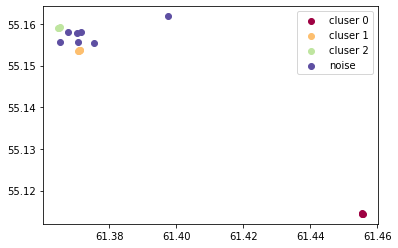

In [17]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.001, min_samples=2).fit(df_event[["lat","lon"]])
df_event["cluster"]=clustering.labels_
unique_labels=set(clustering.labels_)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for i in unique_labels:
    if i!=-1:
        plt.scatter(df_event[df_event["cluster"]==i].lon,df_event[df_event["cluster"]==i].lat,color=colors[i],label="cluser {0}".format(i))
    else:
        plt.scatter(df_event[df_event["cluster"]==i].lon,df_event[df_event["cluster"]==i].lat,color=colors[i],label="noise")
    print(df_event[df_event["cluster"]==i].lat.mean(),df_event[df_event["cluster"]==i].lon.mean())
plt.legend()

Если между событиями одного кластера появилось событие без кластера, принимаем его как аномалию

In [18]:
event=[df_event.iloc[0]]
for i,item in df_event[df_event["cluster"]!=-1][1:].iterrows():
    if event[len(event)-1].cluster != item.cluster:
        event.append(item)
    else:
        event[len(event)-1].end = item.end
pd.DataFrame(event)


,index,start,end,lat,lon,cluster
0,1,2020-02-25 23:24:25,2020-02-26 11:34:45,55.114496,61.455577,0
1,2,2020-02-26 11:56:35,2020-02-26 15:48:45,55.153484,61.370982,1
4,5,2020-02-26 17:10:55,2020-02-26 20:28:05,55.158937,61.364665,2
10,11,2020-02-26 21:00:45,2020-02-27 11:33:15,55.114400,61.455585,0
11,12,2020-02-27 12:04:15,2020-02-27 16:34:45,55.153591,61.370676,1
13,14,2020-02-27 16:39:45,2020-02-27 20:03:25,55.159092,61.364907,2
14,15,2020-02-27 20:21:35,2020-02-28 11:35:15,55.114382,61.455647,0
17,18,2020-02-28 12:38:55,2020-02-28 16:43:25,55.153670,61.370942,1


In [19]:
df

,Unnamed: 0,lon,lat,date,lat_kalman,lon_kalman,nom
0,0,61.4556,55.1146,2020-02-25 23:16:05,55.114600,61.455600,0.0
1,1,61.4557,55.1144,2020-02-25 23:17:07,55.114467,61.455663,62.0
2,2,61.4555,55.1144,2020-02-25 23:17:25,55.114424,61.455562,80.0
3,3,61.4555,55.1144,2020-02-25 23:22:40,55.114407,61.455522,395.0
4,4,61.4556,55.1144,2020-02-25 23:23:19,55.114401,61.455566,434.0
...,...,...,...,...,...,...,...
4995,4995,61.3637,55.1586,2020-02-28 17:34:22,55.158596,61.363671,238697.0
4996,4996,61.3638,55.1585,2020-02-28 17:34:29,55.158536,61.363746,238704.0
4997,4997,61.3637,55.1586,2020-02-28 17:35:15,55.158572,61.363716,238750.0
4998,4998,61.3636,55.1586,2020-02-28 17:35:35,55.158587,61.363644,238770.0


In [20]:
start=df.date.iloc[0]
time = [(start+datetime.timedelta(seconds=i)).minute + (start+datetime.timedelta(seconds=i)).hour*24 for i in range(len(y_lat))]


In [21]:
df_model=pd.DataFrame(np.array([y_lat,y_lon,time]).T, columns = ["lat","lon","time"])

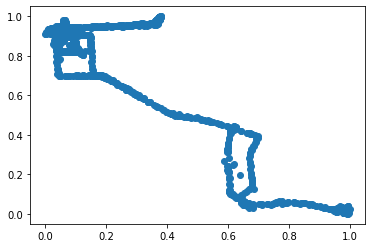

In [22]:
scaler=preprocessing.MinMaxScaler()
df_model["lat_norm"]=scaler.fit_transform(np.array([df_model.lat.values]).T)
df_model["lon_norm"]=scaler.fit_transform(np.array([df_model.lon.values]).T)
df_model["time_norm"]=scaler.fit_transform(np.array([df_model.time.values]).T)
plt.scatter(df_model.lon_norm,df_model.lat_norm)

In [23]:
windows = 15
dataX=[]
dataY=[]
for i,item in df_model[windows:-15].iterrows():
    dataX.append(df_model[["lat_norm","lon_norm","time_norm"]][i-15:i].values)
    dataY.append(df_model[["lat_norm","lon_norm"]][i:i+15].values.reshape(2*windows,1))
dataX=np.array(dataX)
dataY=np.array(dataY)   

In [24]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, 
                                                    train_size=0.8, 
                                                    random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                    train_size=0.75, 
                                                    random_state=42)
X_valid = X_valid.reshape((X_valid.shape[0], 5, 3,3))

In [25]:
y_train.shape

(14309, 30, 1)

In [26]:
X = X_train.reshape((X_train.shape[0], 5, 3,3))

In [36]:
from numpy import array
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras import layers
import tensorflow as tf

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'), input_shape=(None,3, 3)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
#input_shape=(X_train.shape[1], X_train.shape[2])
model.add(GRU(units=1500, activation='relu'))

model.add(Dense(2*windows))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),loss = 'mse',metrics=[tf.keras.metrics.Accuracy()])


In [ ]:
model.fit(X, y_train, epochs=150, batch_size=20,validation_data=(X_valid,y_valid))

Epoch 1/150
716/716 [==============================] - 105s 144ms/step - loss: 0.0766 - accuracy: 0.0000e+00 - val_loss: 5.1858e-04 - val_accuracy: 0.0000e+00
Epoch 2/150
716/716 [==============================] - 98s 137ms/step - loss: 5.2341e-04 - accuracy: 2.7268e-06 - val_loss: 3.3636e-04 - val_accuracy: 0.0000e+00
Epoch 3/150
716/716 [==============================] - 99s 138ms/step - loss: 3.6949e-04 - accuracy: 0.0000e+00 - val_loss: 2.3937e-04 - val_accuracy: 0.0000e+00
Epoch 4/150
716/716 [==============================] - 97s 136ms/step - loss: 3.4135e-04 - accuracy: 1.4990e-06 - val_loss: 2.6257e-04 - val_accuracy: 6.9881e-06
Epoch 5/150
716/716 [==============================] - 97s 135ms/step - loss: 2.9106e-04 - accuracy: 0.0000e+00 - val_loss: 5.2084e-04 - val_accuracy: 0.0000e+00
Epoch 6/150
716/716 [==============================] - 97s 136ms/step - loss: 2.9172e-04 - accuracy: 0.0000e+00 - val_loss: 3.5805e-04 - val_accuracy: 0.0000e+00
Epoch 7/150
716/716 [==========

716/716 [==============================] - 91s 128ms/step - loss: 7.8459e-05 - accuracy: 0.0000e+00 - val_loss: 8.7747e-05 - val_accuracy: 6.9881e-06
Epoch 102/150
716/716 [==============================] - 91s 127ms/step - loss: 1.0063e-04 - accuracy: 3.9531e-06 - val_loss: 1.0391e-04 - val_accuracy: 0.0000e+00
Epoch 103/150
716/716 [==============================] - 90s 126ms/step - loss: 9.9287e-05 - accuracy: 2.5896e-06 - val_loss: 1.2009e-04 - val_accuracy: 0.0000e+00
Epoch 104/150
716/716 [==============================] - 90s 126ms/step - loss: 8.2102e-05 - accuracy: 0.0000e+00 - val_loss: 7.5349e-05 - val_accuracy: 6.9881e-06
Epoch 105/150
716/716 [==============================] - 91s 127ms/step - loss: 6.8835e-05 - accuracy: 1.1864e-05 - val_loss: 9.2931e-05 - val_accuracy: 0.0000e+00
Epoch 106/150
716/716 [==============================] - 91s 126ms/step - loss: 7.4739e-05 - accuracy: 3.2079e-06 - val_loss: 7.4101e-05 - val_accuracy: 0.0000e+00
Epoch 107/150
716/716 [=======

In [38]:
X_t = X_test.reshape((X_test.shape[0], 5, 3,3))
trainPredict= model.predict(X_t)

In [39]:
trainPredict

array([[0.8269893 , 0.09878793, 0.8285477 , ..., 0.09206653, 0.8291052 ,
        0.09220555],
       [0.01689449, 0.9763682 , 0.01827085, ..., 0.976743  , 0.01402879,
        0.9771835 ],
       [0.8279538 , 0.10216522, 0.82989275, ..., 0.09417447, 0.83245015,
        0.09478018],
       ...,
       [0.01566812, 0.9864774 , 0.01700845, ..., 0.8999169 , 0.02464834,
        0.89751846],
       [0.01841816, 0.97526085, 0.01973894, ..., 0.9744252 , 0.01533967,
        0.9748496 ],
       [0.01927763, 0.9731319 , 0.02070859, ..., 0.97952247, 0.01378906,
        0.98041254]], dtype=float32)

In [40]:
trainPredict=trainPredict.reshape(trainPredict.shape[0]*trainPredict.shape[1],1)
trainPredict=trainPredict.reshape(int(trainPredict.shape[0]/2),2)

In [41]:
trainPredict

array([[0.8269893 , 0.09878793],
       [0.8285477 , 0.09923947],
       [0.8294137 , 0.10071868],
       ...,
       [0.01476645, 0.97834414],
       [0.0143505 , 0.97952247],
       [0.01378906, 0.98041254]], dtype=float32)

In [42]:
trainY=y_test.reshape(y_test.shape[0]*y_test.shape[1],1)
trainY=trainY.reshape(int(trainY.shape[0]/2),2)

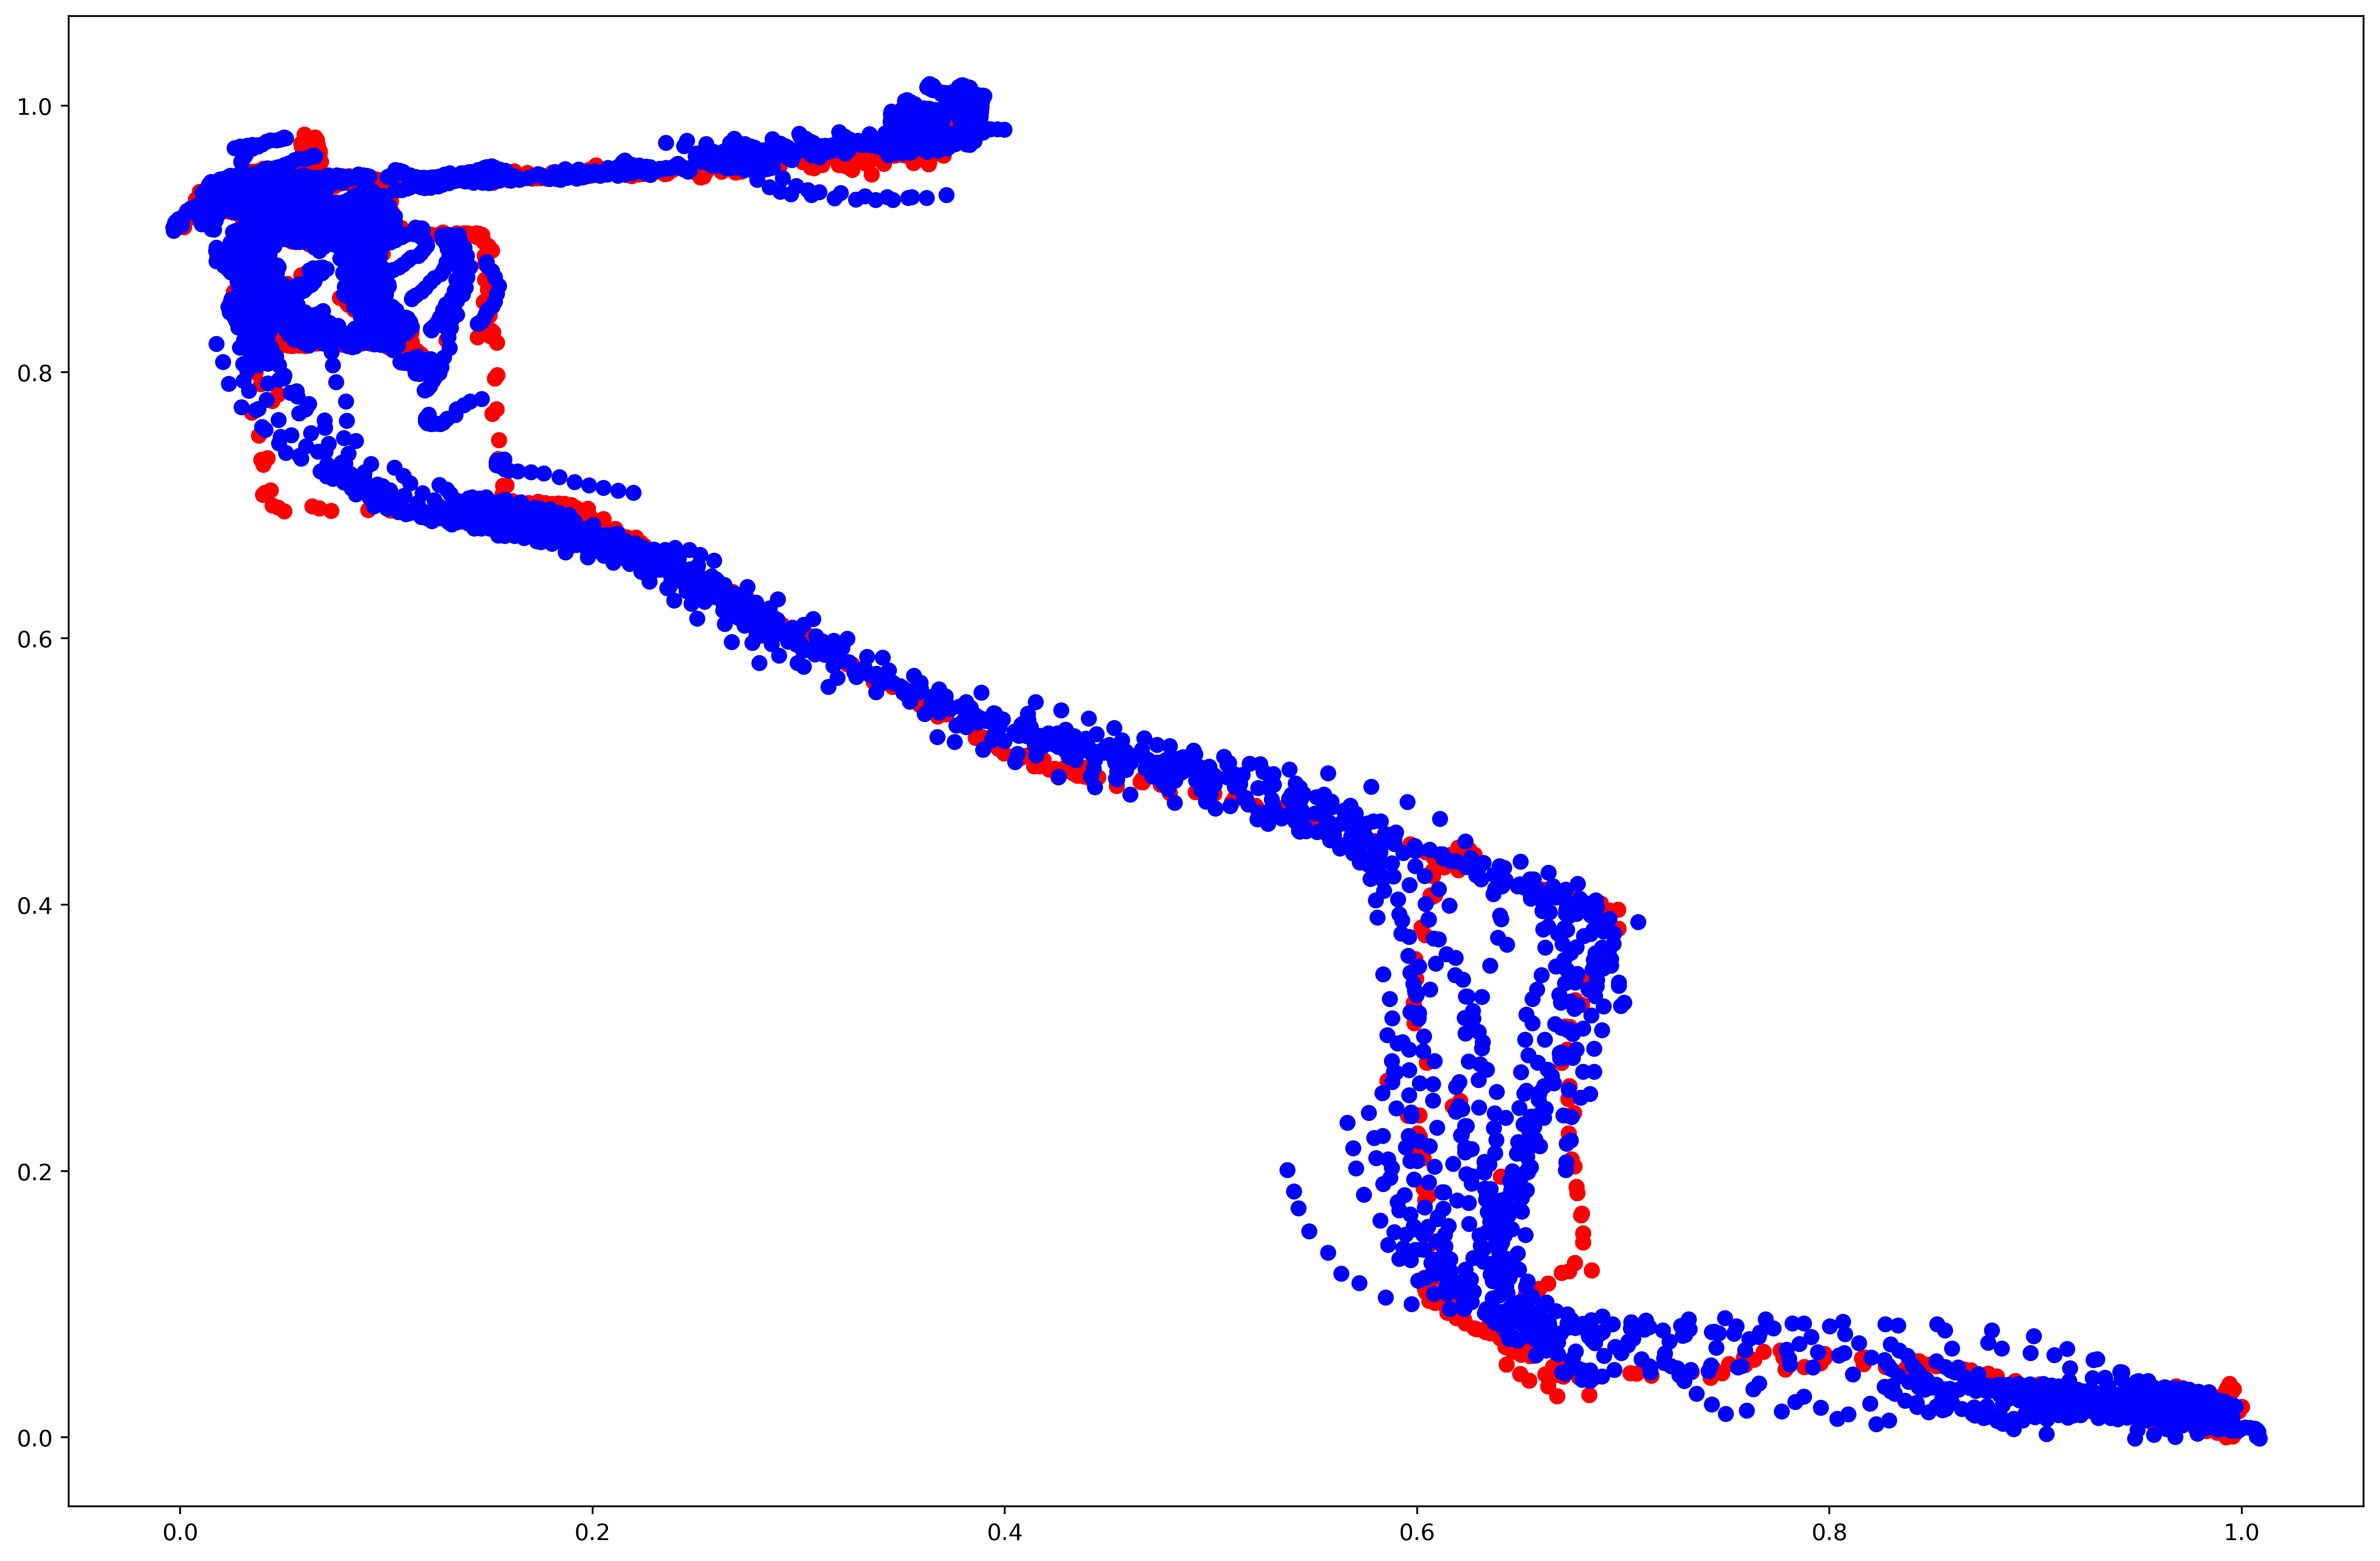

(71550, 2)

In [43]:
plt.figure(figsize=(18, 12), dpi=400)

plt.scatter(trainY.T[1],trainY.T[0], color='red')
plt.scatter(trainPredict.T[1],trainPredict.T[0], color='blue')
plt.show()


trainY.shape

In [244]:
trainY[:,:2]

array([[0.82694392, 0.10084275],
       [0.82708903, 0.10083777],
       [0.82723415, 0.1008328 ],
       ...,
       [0.01226593, 0.98328757],
       [0.01220629, 0.98343233],
       [0.01218602, 0.98348154]])

In [245]:
trainPredict

array([[0.83148503, 0.10525478],
       [0.831452  , 0.10293376],
       [0.83035773, 0.10298404],
       ...,
       [0.01336534, 0.9791151 ],
       [0.01352735, 0.97940516],
       [0.01365192, 0.97899246]], dtype=float32)

In [185]:
onlyData=all_data_proc[:, :2].T
trainYT=trainY[:,:2].T
trainPredictT=trainPredict.T
trainPredictT[0]=trainPredictT[0]*(onlyData[0].max()-onlyData[0].min())+onlyData[0].min()
trainPredictT[1]=trainPredictT[1]*(onlyData[1].max()-onlyData[1].min())+onlyData[1].min()
trainYT[0]=trainYT[0]*(onlyData[0].max()-onlyData[0].min())+onlyData[0].min()
trainYT[1]=trainYT[1]*(onlyData[1].max()-onlyData[1].min())+onlyData[1].min()
trainPredictT=trainPredictT.T
trainYT=trainYT.T
error=np.abs(trainYT[:,:2]-trainPredictT)
print(all_data_proc)
print(np.abs((trainYT[:,:2]-trainPredictT)))
sum_error=np.sum(error, axis=0)/len(error)/(np.sum(trainYT[:,1:2], axis=0)/len(error))

print(np.sum(np.sum(error, axis=0)/len(error))/2)

onlyData=onlyData.T

[[61.4556 55.1144 datetime.datetime(2020, 2, 18, 21, 57, 20)]
 [61.455369080589456 55.11439966016609
  datetime.datetime(2020, 2, 18, 21, 57, 35)]
 [61.45539044203617 55.114402941617506
  datetime.datetime(2020, 2, 18, 21, 57, 50)]
 ...
 [61.36366162468713 55.158570882383344
  datetime.datetime(2020, 2, 28, 17, 35, 20)]
 [61.363667402547264 55.158565834856894
  datetime.datetime(2020, 2, 28, 17, 35, 35)]
 [61.36366798404226 55.15856635755104
  datetime.datetime(2020, 2, 28, 17, 35, 50)]]
[[3.31806629e-06 1.51573324e-06]
 [3.37302293e-06 1.49061282e-06]
 [7.70337607e-07 7.81991773e-07]
 ...
 [2.35157393e-05 3.17902965e-06]
 [2.34608941e-05 7.01885399e-06]
 [2.29159406e-05 6.77620825e-06]]
6.925598792334594e-06


In [173]:
import IPython.display as ipd
ipd.Audio("!qwe.mp3",autoplay=True) 

In [186]:
print(error.min())
print(trainYT[:,:2].min())
print(np.sum(error[trainYT[:,:2]!=0]/(trainYT[:,:2])[trainYT[:,:20]!=0])/len(error[trainYT[:,:2]!=0]))

1.376321279167314e-11
57.76342324472144
1.072989214679952e-07


In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)

In [187]:
model.save('model13_15_-6.h5')